In [2]:
from fastai.vision import *

## Image

Image:       <class 'fastai.vision.image.Image'>
Image.size:  torch.Size([480, 720])
Image.shape: torch.Size([3, 480, 720])
Image.data:  <class 'torch.Tensor'>


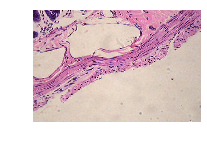

In [365]:
img = open_image("E:/Datasets/TFM/histologyDS2828/imgs/C001_IMG00002.bmp.jpg")

print("Image:      ", type(img))
print("Image.size: ",img.size)
print("Image.shape:",img.shape)
print("Image.data: ",type(img.data))

img.show()

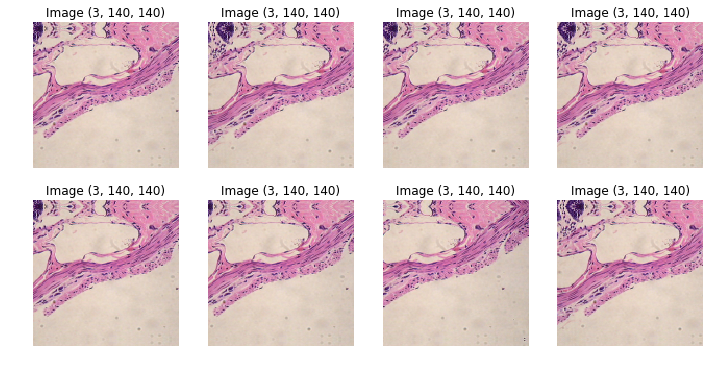

In [541]:
size = 140
tfms = [crop_pad(size=420, row_pct=(0,1), col_pct=(0,1))]
tfms_kwargs = {'size':140}

_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img_t = img.apply_tfms(tfms, **tfms_kwargs)#, size=420)
    img_t.show(ax=ax)
    ax.set_title(img_t)

## Transforms

In [14]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [13]:
tfms = get_transforms(flip_vert=True, max_warp=None)

print("Train transforms:")
for i,t in enumerate(tfms[0]):
    print("  ",i+1, t.tfm)

print("Valid transforms:")
for i,t in enumerate(tfms[1]):
    print("  ",i+1, t.tfm)

Train transforms:
   1 TfmCrop (crop_pad)
   2 TfmAffine (dihedral_affine)
   3 TfmAffine (rotate)
   4 TfmAffine (zoom)
   5 TfmLighting (brightness)
   6 TfmLighting (contrast)
Valid transforms:
   1 TfmCrop (crop_pad)


In [412]:
custom_tfms = [
    rand_crop(),
    dihedral_affine(),
    rotate(degrees=(-10.,10.), p=0.75),
    rand_zoom(scale=(1.,1.1), p=0.75),
    brightness(change=(0.5*(0.8), 0.5*(1.2)), p=0.75),
    contrast(scale=(0.8, 1/(0.8)), p=0.75)
]

custom_tfms

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.1)}, p=0.75, resolved={}, do_run=True, is_random=True)]

## `apply_tfms()`

It will be in charge of picking the values of the random parameters and doing the transformation to the Image object

#### Parameters
- `tfms`: Transformations
- `size`: Int or tuple
- `padding_mode`:
  - `'reflection'`: (default)
  - `'zeros'`
  - `'border'`
- `resize_method`:
  - `ResizeMethod.CROP`: Original ratio resize where **smaller** size corresponds to the given size, then **crops**. Default.
  - `ResizeeMethod.PAD`: Original ratio resize where **bigger** size corresponds to the given size, then fill with **padding**.
  - `ResizeeMethod.SQUISH`: Non original ratio resize to match both sizes.


In [510]:
def _get_zoom_mat(scale:uniform=1.0)->AffineMatrix:
    s = 1-1/scale
    return [[s,  0,  0],
            [0,  s,  0],
            [0,  0, 1.]]
    
def _zoom_squish(c, scale:uniform=1.0):
    #This is intended for scale, squish and invert to be of size 10 (or whatever) so that the transform
    #can try a few zoom/squishes before falling back to center crop (like torchvision.RandomResizedCrop)
    m = _get_zoom_mat(scale)
    return _affine_mult(c, FloatTensor(m))

resizee = TfmCoord(_zoom_squish)

In [519]:
rand_resize_crop(size=64)[0]

RandTransform(tfm=TfmCoord (zoom_squish), kwargs={'scale': (1.0, 2.0, 8), 'squish': (0.75, 1.33, 8), 'invert': (0.5, 8), 'row_pct': (0.0, 1.0), 'col_pct': (0.0, 1.0)}, p=1.0, resolved={}, do_run=True, is_random=True)

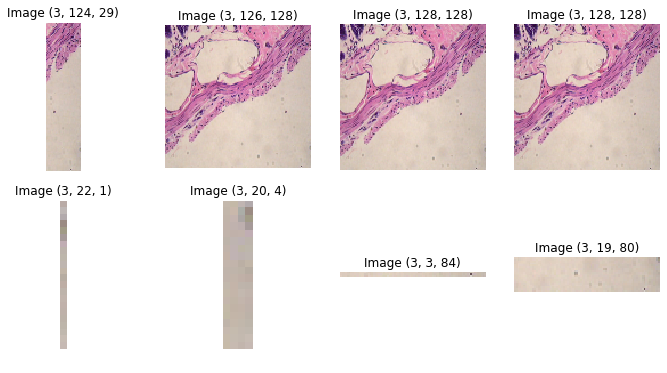

In [525]:
from torchvision import transforms

tfms = [crop(size=420, row_pct=(0,1), col_pct=(0,1)),
       rand_resize_crop(size=64, max_scale=2)[0]]
#tfms = [crop(size=420)]
#tfms = [crop_pad()]
#tfms = [rand_resize_crop(140)]
#tfms = None

size = 140
tfms = [crop(size=420, row_pct=(0,1), col_pct=(0,1))]
tfms_kwargs = {'size':size, 'resize_method':ResizeMethod.SQUISH}
#transform(tfms=tfms, **tfms_kwargs)

_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img_t = img.apply_tfms(tfms, **tfms_kwargs)#, size=420)
    img_t.show(ax=ax)
    ax.set_title(img_t)

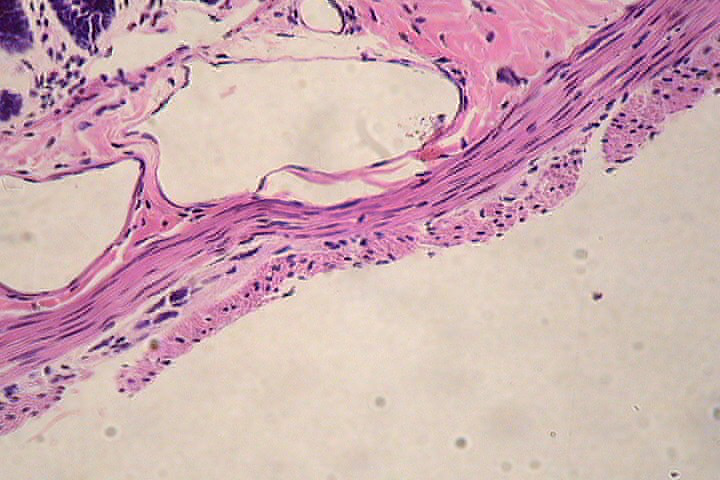

In [422]:
img

In [9]:
from sklearn.model_selection import StratifiedKFold            # Stratified cross validation


In [17]:
tf1 = ([crop_pad(row_pct=(0,1), col_pct=(0,1))],[])
tf2 = ([crop_pad(size=420, row_pct=(0,1), col_pct=(0,1))],[])

In [18]:
path     = pathlib.Path("E:/Datasets/TFM/histologyDS2828")
csv_path = path / "imageClasses.txt"
df       = pd.read_csv(csv_path, header=None, delim_whitespace=True, names=['Image', 'Label'])
df       = df.replace({'Label': {1:"Conective", 2:"Ephitelial", 3:"Muscular", 4:"Nervous"}})

###################################### Stratified 10 Fold Cross validation indexes
n_cv_folds = 10
x = df.Image.values
y = df.Label.values
train_idxs_fold = []
valid_idxs_fold = []
cross_valid = StratifiedKFold(n_splits=n_cv_folds, shuffle=True)
for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):
    train_idxs_fold.append(train_index)
    valid_idxs_fold.append(valid_index)

###################################### Get mean and std
#mean = np.zeros(3)  # float64
#std  = np.zeros(3)  # float64
#for img in tqdm(src):
#    mean += img.data.numpy().mean(axis=(1,2)) # float32
#    std  += img.data.numpy().std(axis=(1,2))
#mean /= 2828
#std  /= 2828
his2828_mean  = [0.842652, 0.554769, 0.578314]
his2828_std   = [0.114894, 0.137445, 0.108943]

##################################### Src data

src  = ImageItemList.from_df(df, path, folder='imgs')
data = (src.split_by_idxs(train_idxs_fold[0], valid_idxs_fold[0])
        .label_from_df(cols='Label')
        .transform(tf1, size=140)
        .databunch(bs=16)
        .normalize((his2828_mean,his2828_std)))

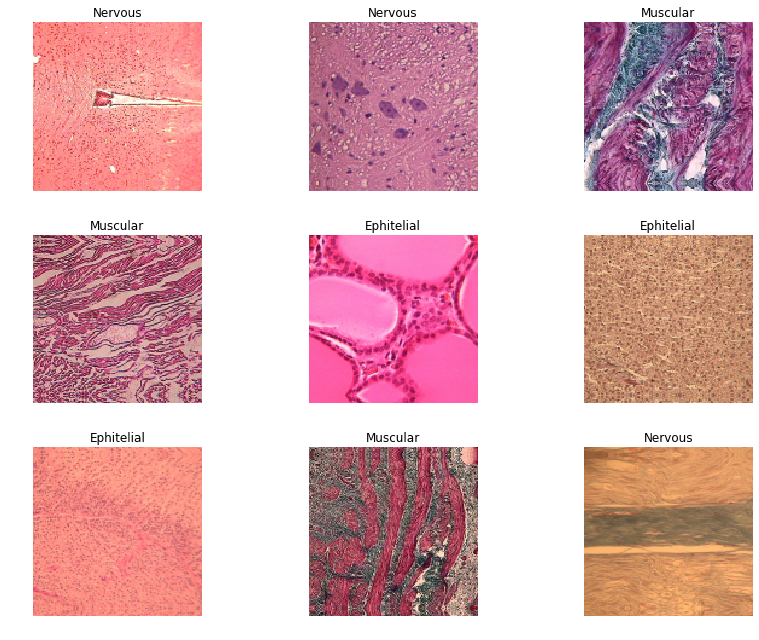

In [19]:
data.show_batch(rows=3, figsize=(12,9))